# ANN, excluding Cys-epitopes

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-01-13 15:11:44.245279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 15:11:44.252551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 15:11:44.260814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 15:11:44.263281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 15:11:44.269806: I tensorflow/core/platform/cpu_feature_guar

In [20]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()
print_gpu_memory()

import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
2633803,VECFIGS,0,41.142857,1.031429,7.471429,0.136714,2.957143,49.0,1.07,5.90,...,1,1,0,0,1,0,1,0,0,1
1169817,VVRPLGSEN,0,13.888889,0.818889,8.588889,0.137222,3.020000,-5.0,0.60,9.00,...,0,0,1,0,0,1,1,0,0,1
1225941,ALKYLNEIKP,0,24.600000,1.255000,8.380000,0.175600,3.846000,9.0,1.34,8.05,...,0,1,1,1,0,1,0,0,1,0
2830096,MELEKPVLI,1,34.666667,1.313333,7.833333,0.174556,3.831111,74.0,1.32,5.90,...,0,1,1,1,0,1,0,0,0,1
3261094,EAYIPPQVFYN,0,25.545455,1.305455,7.927273,0.180455,3.904545,41.0,1.88,8.00,...,0,1,0,0,1,1,0,0,1,1


In [3]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn

## filter I: without Cys

In [4]:
# keep epitopes without Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==1) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Cys: (1639058, 50)
epitopes having Cys: (226184, 50)
filtered data: (3232054, 49)


In [5]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3232054, 47) float16
y: (3232054,) float16
labels: Counter({1.0: 1639058, 0.0: 1592996})
train data: (1809950, 47) (1809950,)
validate data: (775693, 47) (775693,)
test data (646411, 47) (646411,)


In [6]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1736799229.195773   40788 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736799229.222133   40788 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736799229.222263   40788 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736799229.223148   40788 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1736799230.332837   41081 service.cc:146] XLA service 0x72af00004780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736799230.332863   41081 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-13 15:13:50.363155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-13 15:13:50.448440: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


   73/56561 ━━━━━━━━━━━━━━━━━━━━ 1:59 2ms/step - accuracy: 0.5893 - auc: 0.6375 - loss: 0.6598 - mse: 0.2344 - precision: 0.5932 - recall: 0.6275 

I0000 00:00:1736799231.323381   41081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56561/56561 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.6929 - auc: 0.7651 - loss: 0.5569 - mse: 0.1932 - precision: 0.6635 - recall: 0.8008 - val_accuracy: 0.7130 - val_auc: 0.7911 - val_loss: 0.5349 - val_mse: 0.1839 - val_precision: 0.6800 - val_recall: 0.8204
Epoch 2/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.7123 - auc: 0.7872 - loss: 0.5391 - mse: 0.1852 - precision: 0.6809 - recall: 0.8138 - val_accuracy: 0.7227 - val_auc: 0.8014 - val_loss: 0.5261 - val_mse: 0.1799 - val_precision: 0.6835 - val_recall: 0.8444
Epoch 3/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.7188 - auc: 0.7946 - loss: 0.5322 - mse: 0.1822 - precision: 0.6897 - recall: 0.8111 - val_accuracy: 0.7269 - val_auc: 0.8037 - val_loss: 0.5230 - val_mse: 0.1785 - val_precision: 0.6988 - val_recall: 0.8115
Epoch 4/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step - accuracy: 0.7210 - auc: 0.7973 - loss: 0.5297 - mse: 0.1811 - precision: 0.6929 - recall: 0.8091 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.699728,0.773703,0.550014,0.190194,0.668600,0.809618,0.713024,0.791128,0.534913,0.183871,0.679977,0.820448
1,0.714743,0.789805,0.536574,0.184163,0.683810,0.814553,0.722698,0.801423,0.526091,0.179947,0.683494,0.844399
2,0.719252,0.795165,0.531602,0.181973,0.690361,0.810164,0.726907,0.803718,0.522968,0.178485,0.698763,0.811531
3,0.721483,0.797609,0.529343,0.180987,0.693552,0.808366,0.726084,0.805343,0.523638,0.178813,0.689096,0.838259
4,0.722621,0.798806,0.528289,0.180490,0.695316,0.807096,0.729050,0.806625,0.519957,0.177190,0.705251,0.800431
5,0.723459,0.800096,0.527105,0.179977,0.696640,0.806111,0.729038,0.807746,0.518551,0.176708,0.694049,0.833149
6,0.723938,0.800550,0.526770,0.179808,0.696916,0.806970,0.728556,0.808160,0.518523,0.176750,0.691888,0.838196
7,0.724249,0.801076,0.526261,0.179587,0.697859,0.805292,0.730366,0.809402,0.516963,0.176073,0.696399,0.830608
8,0.724876,0.801733,0.525655,0.179309,0.698222,0.806412,0.730807,0.809593,0.516066,0.175705,0.698119,0.826961
9,0.724971,0.802051,0.525392,0.179193,0.698453,0.806071,0.732268,0.810141,0.516360,0.175651,0.706324,0.808337


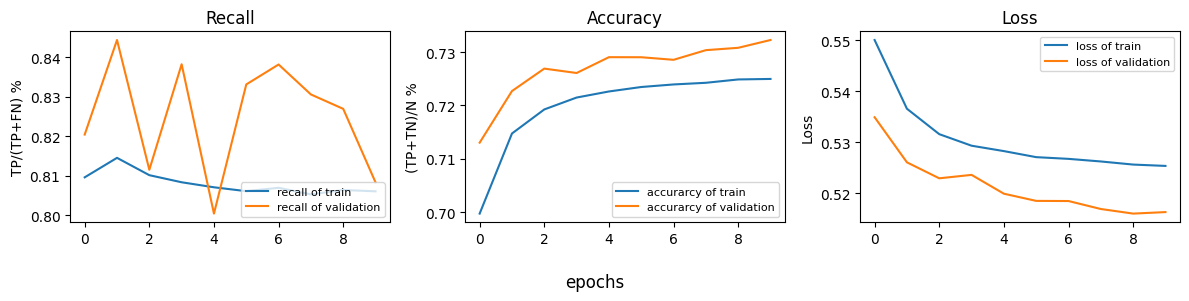

In [7]:
# evaluate model
c.plot_acc_recall()

20201/20201 ━━━━━━━━━━━━━━━━━━━━ 19s 951us/step - accuracy: 0.7310 - auc: 0.8087 - loss: 0.5179 - mse: 0.1764 - precision: 0.7043 - recall: 0.8070
{'accuracy': 0.7310503721237183, 'auc': 0.8088809251785278, 'loss': 0.5176863670349121, 'mse': 0.17626363039016724, 'precision': 0.7041643261909485, 'recall': 0.8076920509338379}
20201/20201 ━━━━━━━━━━━━━━━━━━━━ 7s 356us/step
[[0.        ]
 [0.6462344 ]
 [0.03555201]]


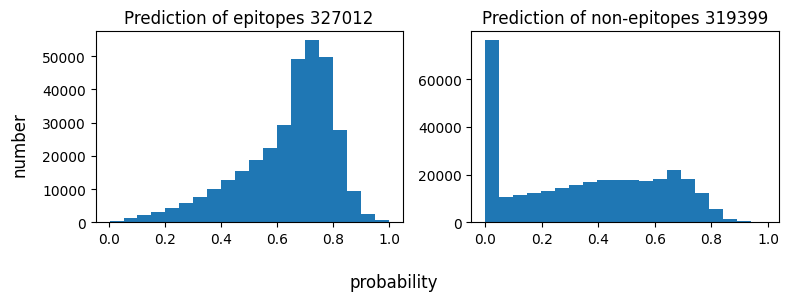

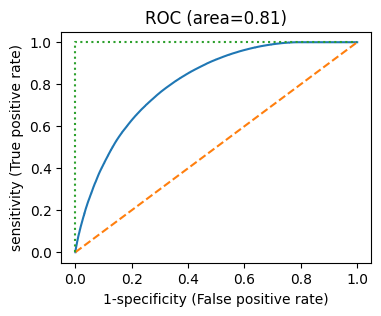

In [8]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [9]:
# save entire model
c.save_model('../models/epitopes_ann_notCys.keras')

<Sequential name=sequential, built=True>

## filter II: having Cys

In [10]:
# keep epitopes container Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==0) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Cys: (1639058, 50)
epitopes having Cys: (226184, 50)
filtered data: (1819180, 49)


In [11]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (1819180, 47) float16
y: (1819180,) float16
labels: Counter({0.0: 1592996, 1.0: 226184})
train data: (1018740, 47) (1018740,)
validate data: (436604, 47) (436604,)
test data (363836, 47) (363836,)


In [12]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9064 - auc: 0.9430 - loss: 0.1860 - mse: 0.0627 - precision: 0.6414 - recall: 0.5577 - val_accuracy: 0.9157 - val_auc: 0.9538 - val_loss: 0.1718 - val_mse: 0.0573 - val_precision: 0.6735 - val_recall: 0.6211
Epoch 2/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9142 - auc: 0.9516 - loss: 0.1745 - mse: 0.0586 - precision: 0.6641 - recall: 0.6334 - val_accuracy: 0.9180 - val_auc: 0.9557 - val_loss: 0.1669 - val_mse: 0.0558 - val_precision: 0.6620 - val_recall: 0.6911
Epoch 3/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.9155 - auc: 0.9526 - loss: 0.1726 - mse: 0.0578 - precision: 0.6614 - recall: 0.6558 - val_accuracy: 0.9187 - val_auc: 0.9564 - val_loss: 0.1668 - val_mse: 0.0557 - val_precision: 0.6591 - val_recall: 0.7128
Epoch 4/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9165 - auc: 0.9537 - loss: 0.1716 - mse: 0.0573 - precision: 0.6576 - recall: 0.6940 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.910788,0.948643,0.178868,0.060279,0.655391,0.601240,0.915727,0.953789,0.171758,0.057293,0.673507,0.621105
1,0.914593,0.952016,0.173864,0.058313,0.663382,0.640704,0.917987,0.955679,0.166945,0.055780,0.661999,0.691129
2,0.916104,0.953243,0.172041,0.057544,0.662152,0.669100,0.918702,0.956447,0.166791,0.055730,0.659051,0.712752
3,0.916910,0.953944,0.170953,0.057067,0.657089,0.698889,0.919579,0.957216,0.165434,0.055163,0.662967,0.714156
4,0.917615,0.954771,0.169554,0.056519,0.655606,0.715856,0.919884,0.957512,0.164908,0.054965,0.657870,0.736666
5,0.918091,0.955372,0.168691,0.056178,0.655741,0.723415,0.920594,0.957854,0.164810,0.055003,0.666108,0.720384
6,0.918656,0.955890,0.167813,0.055824,0.656339,0.730817,0.920676,0.958342,0.162924,0.054145,0.652970,0.768250
7,0.919044,0.956058,0.167493,0.055684,0.656466,0.736881,0.920866,0.958372,0.162754,0.054108,0.657890,0.753114
8,0.919321,0.956308,0.167152,0.055536,0.656729,0.740586,0.921849,0.958968,0.162048,0.053755,0.658741,0.766494
9,0.919474,0.956586,0.166718,0.055350,0.656374,0.744441,0.921098,0.959046,0.162207,0.053911,0.654813,0.768435


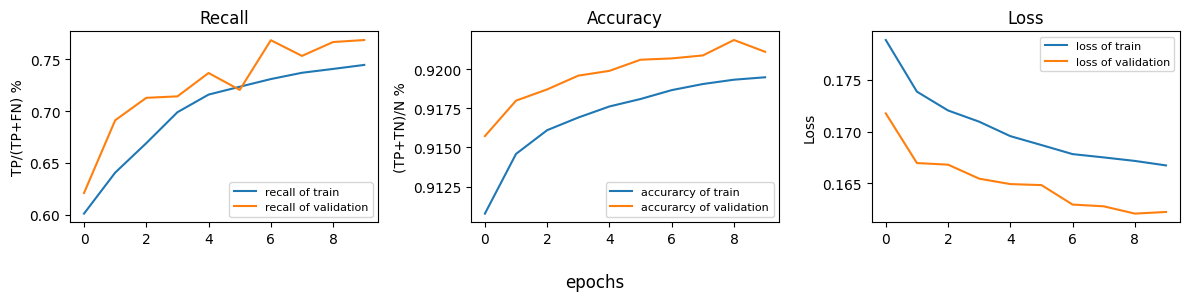

In [13]:
# evaluate model
c.plot_acc_recall()

11370/11370 ━━━━━━━━━━━━━━━━━━━━ 10s 892us/step - accuracy: 0.9203 - auc: 0.9587 - loss: 0.1625 - mse: 0.0541 - precision: 0.6513 - recall: 0.7642
{'accuracy': 0.9202553033828735, 'auc': 0.9585360288619995, 'loss': 0.16285951435565948, 'mse': 0.054215654730796814, 'precision': 0.6506534814834595, 'recall': 0.7654244303703308}
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 4s 326us/step
[[2.134325e-33]
 [9.613082e-18]
 [2.357164e-24]]


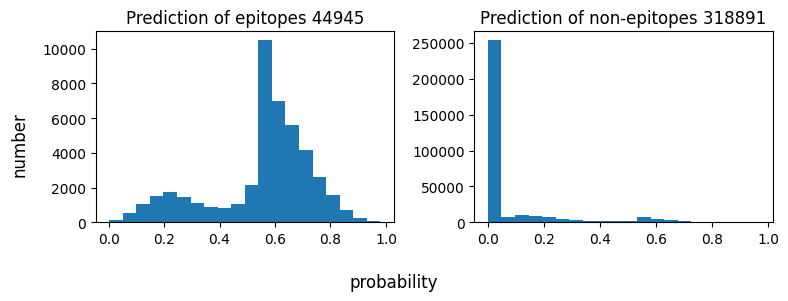

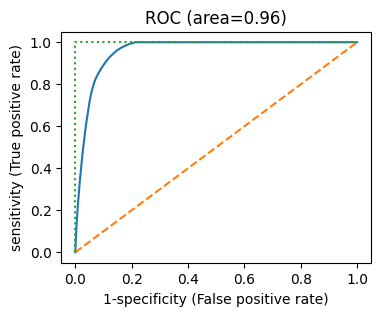

In [14]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [15]:
# save entire model
c.save_model('../models/epitopes_ann_hasCys.keras')

<Sequential name=sequential_1, built=True>